In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (16, 5)
sns.set()

In [3]:
robusta_df = pd.read_html(
    "https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=236"
)[1]

In [4]:
print(robusta_df.head())
print(robusta_df.info())

      Month  Price   Change
0  Jul 2001   0.60        -
1  Aug 2001   0.57  -5.00 %
2  Sep 2001   0.54  -5.26 %
3  Oct 2001   0.51  -5.56 %
4  Nov 2001   0.52   1.96 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   236 non-null    object 
 1   Price   236 non-null    float64
 2   Change  236 non-null    object 
dtypes: float64(1), object(2)
memory usage: 5.7+ KB
None


In [5]:
df = robusta_df.copy()
df['Month'] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df = df.set_index('Month')
df.index.freq = 'MS'

df.head()

,Price,Change
Month,,
2001-07-01,0.60,-
2001-08-01,0.57,-5.00 %
2001-09-01,0.54,-5.26 %
2001-10-01,0.51,-5.56 %
2001-11-01,0.52,1.96 %


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2001-07-01 to 2021-02-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   236 non-null    float64
 1   Change  236 non-null    object 
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


<AxesSubplot:xlabel='Month'>

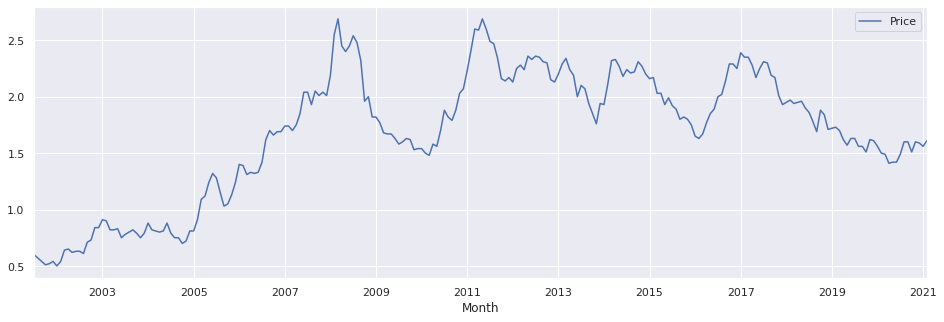

In [7]:
df.plot()

### Stationarity test

In [8]:
P_THRESHOLD = 0.05


def adf_test(series):
    _, p_value, *_rest = adfuller(series, autolag="AIC")
    print(
        f"p-value of ADF test is {p_value}, data is "
        f"{'stationary' if p_value < P_THRESHOLD else 'non stationary'}"
    )

In [9]:
adf_test(df['Price'])

p-value of ADF test is 0.2044938387421863, data is non stationary


### Fitting AR model

#### Splitting into training and test set

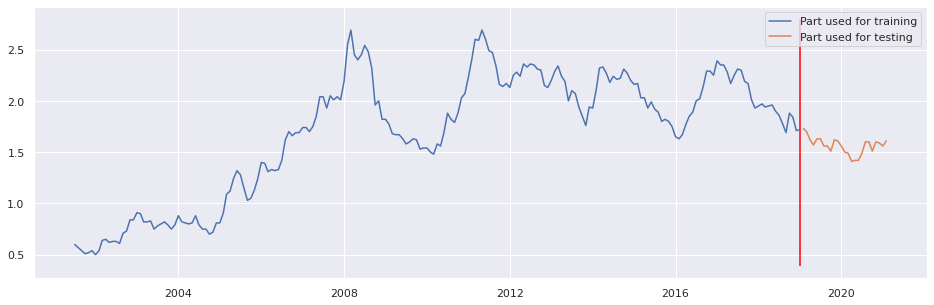

In [10]:
full_df = df.copy()
df_train = df[:"Jan 2019"]
df_test = df["Feb 2019":]
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.plot(df_train.index, df_train["Price"], label="Part used for training")
ax.plot(df_test.index, df_test["Price"], label="Part used for testing")
y_low, y_high = ax.get_ylim()
ax.vlines("2019-01-01", y_low, y_high, colors="red")
ax.legend()

#### Create AR model and fit to the training data

In [11]:
def fit_model(series, order):
    ar_model = ARIMA(series, order=(order, 0, 0))
    ar_fitted = ar_model.fit()

    return ar_fitted

In [18]:
def select_best_aic(series, orders_to_check=range(1, 6)):
    best_model, best_order, best_aicc = None, None, None
    for order in orders_to_check:
        fitted_model = fit_model(series, order)
        model_aicc = fitted_model.aicc
        print(f"AR({order}) AICC: {model_aicc: .4f}")
        if not best_model or model_aicc < best_aicc:
            best_model = fitted_model
            best_aicc = model_aicc
            best_order = order

    print(f"Best model is AR({best_order}) with AIC: {best_aicc: .4f}")
    return best_model, best_order

In [13]:
best_model, model_order = select_best_aic(df_train[['Price']])

print("\nBest Model summary:")
best_model.summary()

AR(1) AIC: -402.9717
AR(2) AIC: -415.8112
AR(3) AIC: -413.7349
AR(4) AIC: -411.7487
AR(5) AIC: -409.7098
Best model is AR(2) with AIC: -415.8112

Best Model summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  211
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 212.003
Date:                Tue, 27 Apr 2021   AIC                           -416.005
Time:                        14:53:05   BIC                           -402.598
Sample:                    07-01-2001   HQIC                          -410.586
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5170      0.317      4.779      0.000       0.895       2.139
ar.L1          1.2484      0.057     21.755      0.000       1.136       1.361
ar.L2         -0.2617      0.058     -4.543      0.000      -0.375      -0.149
sigma2         0.0077      0.001     11.746      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.81
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               1.81   Skew:                             0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
dt = df_test.index.to_period("M").max() - df_train.index.to_period("M").max()
months_to_predict = dt.n

fitted_values = best_model.fittedvalues
forecasted_values = best_model.forecast(months_to_predict)

full_df[f"AR({model_order}) fitted values"] = fitted_values
full_df[f"AR({model_order}) forecast values"] = forecasted_values
full_df[f"AR({model_order}) combined values"] = pd.concat(
    [fitted_values, forecasted_values]
)

<AxesSubplot:xlabel='Month'>

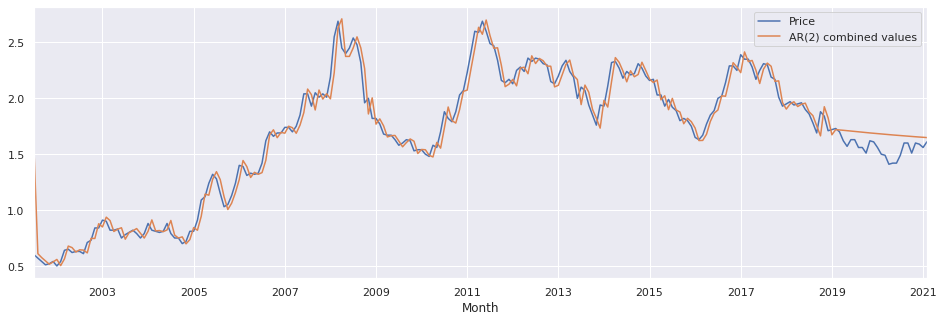

In [15]:
full_df.plot(y=["Price", f"AR({model_order}) combined values"], figsize=(16, 5))

In [16]:
prediction_mse = np.sum((df_test["Price"] - forecasted_values).to_numpy() ** 2)
print(f"AR({model_order}) model prediction MSE: {prediction_mse:.2f}")

AR(2) model prediction MSE: 0.48


AR(2) residuals mean: 0.001988150308708512
AR(2) residuals std: 0.10798438785025441
p-value of ADF test is 3.880670996927053e-30, data is stationary


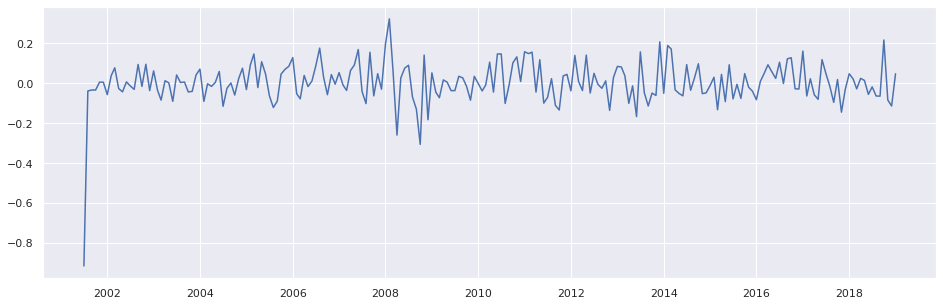

In [17]:
print(f"AR({model_order}) residuals mean: {best_model.resid.mean()}")
print(f"AR({model_order}) residuals std: {best_model.resid.std()}")
adf_test(best_model.resid)

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.plot(best_model.resid);